In [1]:
# add capability to import from parent directory
import sys, os
sys.path.insert(1, os.path.join(os.path.abspath('.'), '..'))

import pvmismatch as pvm
import pvlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

C:\Users\cwhanse\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Setting PV system layout cell and module parameters
str_len = 6 # number of modules in a string
str_num = 3 # number of (parallel connected) strings in the array
v_bypass = np.float64(-0.5)  # [V] trigger voltage of bypass diode
cell_area = np.float64(246.49)  # [cm^2] cell area
Isc0_T0 = 9.68 # [A] reference short circuit current
ncols_per_substr=[2]*3 # 3 bypass diodes with 2 series connected cell-columns
nrows=10 # number of cell rows in the module

# Building PV modules and system
pv_mod_pattern = pvm.pvmodule.standard_cellpos_pat(nrows=nrows,
                                                   ncols_per_substr=ncols_per_substr)
pv_mod = pvm.pvmodule.PVmodule(cell_pos=pv_mod_pattern, pvcells=None,
                               pvconst=None, Vbypass=v_bypass, cellArea=cell_area)


In [3]:
pv_cells = pv_mod.pvcells
for c in pv_cells:
    c.update(diode_model = 'pvsyst', aRBD=0.0, bRBD=0.0, Isc0_T0 = Isc0_T0) # updating short circuit currents

pv_mod.setSuns(cells=list(range(0, len(pv_cells))), Ee=[1]*len(pv_cells))

pv_str = pvm.pvstring.PVstring(numberMods=str_len, pvmods=[pv_mod]*str_len)

pv_sys = pvm.pvsystem.PVsystem(numberStrs=str_num, pvstrs=[pv_str]*str_num,
                               numberMods=[str_len]*str_num,
                               pvmods=[pv_mod]*str_len)

<PVcell(Ee=1[suns], Tcell=298.15[K], Isc=9.68[A], Voc=0.687842[V])>
(9.684125625749223, 2.28618816125344e-11, 0.004267236774264931, 10.01226369025448, 0.025692570400413114)


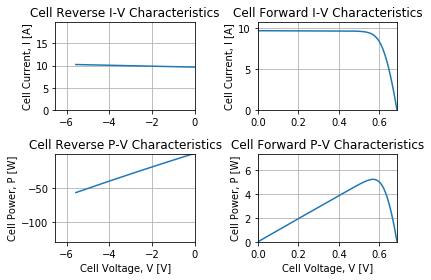

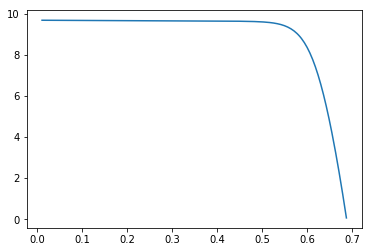

In [4]:
pv_cells[0].plot()

print(pv_mod.pvcells[0])

(photocurrent, saturation_current, resistance_series, resistance_shunt, nVth) = \
    pv_mod.pvcells[0].Aph * pv_mod.pvcells[0].Isc, pv_mod.pvcells[0].Isat1, \
    pv_mod.pvcells[0].Rs, pv_mod.pvcells[0].Rsh, \
    pv_mod.pvcells[0].N1 * pv_mod.pvcells[0].Vt

print((photocurrent, saturation_current, resistance_series, resistance_shunt, nVth))

(V_pvm, I_pvm) = pv_mod.pvcells[0].Vcell, pv_mod.pvcells[0].Icell
u = (V_pvm>=0.) & (I_pvm>=0.)
I_pvm = I_pvm[u]
V_pvm = V_pvm[u]

plt.figure()
plt.plot(V_pvm, I_pvm)
plt.show()

Difference between pvlib and PVMismatch IV curves
brentq :  1.763750812067144e-10
newton :  4.048317236993171e-12
lambertw :  1.5987211554602254e-14


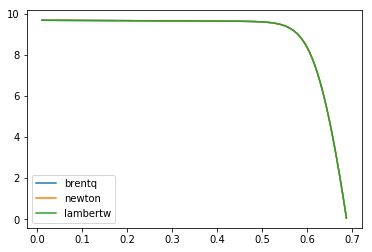

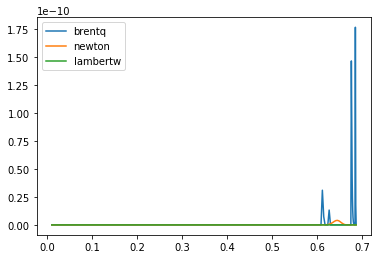

In [5]:
# Analysis with cell-level IV curves

v_pvl = V_pvm

# pvlib has three numerical methods to solve the single diode equation. Let's find which method gives the best agreement
# with PVMismatch, and which has the smallest error.
methods = ['brentq', 'newton', 'lambertw']
i_pvl = pd.DataFrame(index=methods, columns=['current'])

for method in methods:
    res = pvlib.pvsystem.i_from_v(resistance_shunt, resistance_series, nVth, V_pvm, saturation_current, photocurrent,
                                            method=method)
    i_pvl['current'][method] = res

plt.figure()
for method in methods:
    plt.plot(v_pvl, i_pvl['current'][method])
plt.legend(methods)

plt.figure()
for method in methods:
    plt.plot(v_pvl, np.abs(i_pvl['current'][method] - I_pvm))
plt.legend(methods)

print("Difference between pvlib and PVMismatch IV curves")
for method in methods:
    print(method, ': ', np.max(np.abs(i_pvl['current'][method] - I_pvm)))


brentq : 4.49089099241462e-10
newton : 7.028155835087091e-12
lambertw : 2.7977620220553945e-14


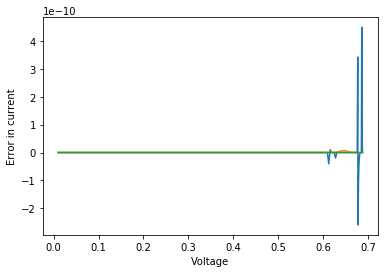

In [6]:
def sde_resid(v, i, iph, io, rs, rsh, nNsVth):
    """
    Calculate the residual for current for a single diode equation at (v, i).
    """
    return iph - io * np.expm1((v + i * rs) / nNsVth) - (v + i * rs) / rsh - i

i_resid = pd.DataFrame(index=methods, columns=['current'])
for method in methods:
    i_resid['current'][method] = sde_resid(v_pvl, i_pvl['current'][method], iph=photocurrent,
                                           io=saturation_current, rs=resistance_series,
                                           rsh=resistance_shunt, nNsVth=nVth)

plt.figure()
for method in methods:
    plt.plot(v_pvl, i_resid['current'][method])
plt.ylabel('Error in current')
plt.xlabel('Voltage')

for method in methods:
    print(method, ':', np.max(np.abs(i_resid['current'][method])))


[4.18332036e-13 4.18332036e-13 1.41179329e+01 2.65394398e+01
 2.94990578e+01 3.05834944e+01 3.12530092e+01 3.17322097e+01
 3.21092076e+01 3.24247031e+01 3.26963363e+01 3.29342441e+01
 3.31462463e+01 3.33383632e+01 3.35152204e+01 3.36803625e+01
 3.38364987e+01 3.39785595e+01 3.41150955e+01 3.42476392e+01
 3.43689905e+01 3.44888708e+01 3.46027584e+01 3.47126789e+01
 3.48201046e+01 3.49223410e+01 3.50240373e+01 3.51203865e+01
 3.52170039e+01 3.53088833e+01 3.54010016e+01 3.54895269e+01
 3.55776646e+01 3.56637130e+01 3.57483355e+01 3.58325946e+01
 3.59141211e+01 3.59971290e+01 3.60759388e+01 3.61566613e+01
 3.62345531e+01 3.63128457e+01 3.63906054e+01 3.64667898e+01
 3.65446380e+01 3.66190089e+01 3.66951847e+01 3.67699424e+01
 3.68445385e+01 3.69199690e+01 3.69932423e+01 3.70682938e+01
 3.71416084e+01 3.72155496e+01 3.72899139e+01 3.73629731e+01
 3.74378053e+01 3.75107997e+01 3.75849482e+01 3.76592460e+01
 3.77329181e+01 3.78083780e+01 3.78819070e+01 3.79570806e+01
 3.80320990e+01 3.810717

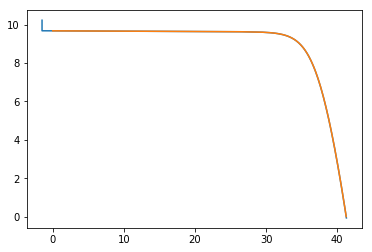

In [7]:
# Analysis with module-level IV curves

Vmod = pv_mod.Vmod
Imod = pv_mod.Imod

plt.figure()
plt.plot(Vmod, Imod)

# remove negative voltage and current

u = (Vmod>=0.) & (Imod>=0.)
Imod = Imod[u]
Vmod = Vmod[u]

print(Vmod)
print(Imod)

plt.plot(Vmod, Imod)

Difference between pvlib and PVMismatch IV curves
brentq :  0.0015364870781562345
newton :  0.0015364870781704454
lambertw :  0.0015364870781695572


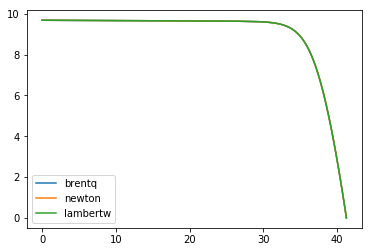

In [8]:
Ns = 60

i_pvl_mod = pd.DataFrame(index=methods, columns=['current'])

for method in methods:
    i_pvl_mod['current'][method] = pvlib.pvsystem.i_from_v(resistance_shunt=Ns*resistance_shunt,
                                                      resistance_series=Ns*resistance_series,
                                                      nNsVth=Ns*nVth, voltage=Vmod,
                                                      saturation_current=saturation_current,
                                                      photocurrent=photocurrent, method=method)

plt.figure()
for method in methods:
    plt.plot(Vmod, i_pvl_mod['current'][method])
plt.legend(methods)

print("Difference between pvlib and PVMismatch IV curves")
for method in methods:
    print(method, ': ', np.max(np.abs(i_pvl_mod['current'][method] - Imod)))

brentq : 4.9432680171435095e-12
newton : 5.062616992290714e-14
lambertw : 2.7533531010703882e-14


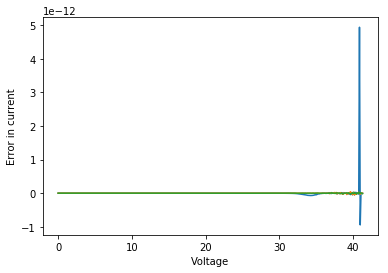

In [9]:
i_pvl_resid = pd.DataFrame(index=methods, columns=['current'])

for method in methods:
    i_pvl_resid['current'][method] = sde_resid(v=Vmod, i=i_pvl_mod['current'][method],
                                               iph=photocurrent, io=saturation_current,
                                               rs=resistance_series*Ns, rsh=resistance_shunt*Ns,
                                               nNsVth=nVth*Ns)

    
plt.figure()
for method in methods:
    plt.plot(Vmod, i_pvl_resid['current'][method])
plt.ylabel('Error in current')
plt.xlabel('Voltage')

for method in methods:
    print(method, ':', np.max(np.abs(i_pvl_resid['current'][method])))

In [ ]:
# The analysis above identifies 'lambertw' as having lowest discrepancy between pvlib and PVMismatch, and curves
# calculated with 'lambertw' as having smallest residual

In [36]:
# converge IV curves to remove small errors in current

from scipy.optimize import newton

def _fi(i, v, iph, io, rs, rsh, nNsVth):
    return iph - io * np.expm1((v + i * rs) / nNsVth) - (v + i * rs) / rsh - i

def _dfdi(i, v, iph, io, rs, rsh, nNsVth):
    return -io * rs / nNsVth * np.exp(v / nNsVth) * np.exp(i * rs / nNsVth) - rs / rsh - 1

method = 'lambertw'
i_converged = pd.Series(index=i_pvl_mod['current'][method], data=np.nan)
for (v, i) in zip(Vmod, i_pvl_mod['current'][method]):
    try:
        i_converged[i] = newton(func=_fi, x0=i, fprime=_dfdi, args=(v, photocurrent, saturation_current, resistance_series*Ns,
                                resistance_shunt*Ns, nVth*Ns), tol=1e-16)
    except:
        i_converged[i] = np.nan

print(np.max(np.abs(i_converged - i_pvl_mod['current'][method])))
print(i_converged)

1.4569048007936902e-14
9.680000    9.680000
9.680000    9.680000
9.656508    9.656508
9.632448    9.632448
9.607871    9.607871
              ...   
0.973900    0.973900
0.739109         NaN
0.498667    0.498667
0.252367    0.252367
0.000085    0.000085
Length: 102, dtype: float64


'1.1.0'